# A) Generate synthetic data.

In [1]:
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np


In [2]:
def generate_synthetic_data(
        n_samples: int = 1000,
        n_features: int = 20,
        n_informative: int = 5,
        n_redundant: int = 5,
        n_repeated: int = 2,
        n_classes: int = 2,
        class_sep: float = 1.0,
        flip_y: float = 0.01,
        random_state: bool = None
        ) -> tuple[pd.DataFrame, pd.Series]:
    """
    Generate a synthetic dataset for classification purposes.

    Parameters:
    - n_samples: int, number of samples
    - n_features: int, total number of features
    - n_informative: int, number of informative features
    - n_redundant: int, number of redundant features
    - n_repeated: int, number of repeated features
    - n_classes: int, number of classes
    - class_sep: float, the factor to separate the classes
    - flip_y: float, fraction of samples whose class are randomly exchanged
    - random_state: int or None, random seed for reproducibility

    Returns:
    - X: pd.DataFrame, generated features
    - y: pd.Series, target labels
    """
    X, y = make_classification(
        n_samples=n_samples, n_features=n_features,
        n_informative=n_informative, n_redundant=n_redundant,
        n_repeated=n_repeated, n_classes=n_classes, class_sep=class_sep,
        flip_y=flip_y, random_state=random_state
        )

    feature_names = [f"Feature_{i+1}" for i in range(n_features)]
    X = pd.DataFrame(X, columns=feature_names)
    y = pd.Series(y, name="Class")

    return X, y


In [3]:
x, y = generate_synthetic_data(100, 20)

print(x)


    Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0    1.136467  -3.565904  -5.881832  -4.981019   3.397632  -0.456054   
1    3.497852   0.505860   0.318994  -2.487607  -2.567296   0.898072   
2    1.188345  -1.191185  -1.920648  -2.019394  -0.019544   0.092255   
3   -3.061106  -1.800870  -1.453351   2.054543  -0.680263  -0.196470   
4    0.363907   1.661362   0.738278   0.991955  -1.565568   0.571628   
..        ...        ...        ...        ...        ...        ...   
95   2.205694   4.004747  -2.290006   0.309235  -1.005379   1.403749   
96  -1.705389  -3.458757   3.832305  -0.219499   0.145726   1.180642   
97   1.550985   2.597506  -1.967964   0.543125  -0.833942   0.869553   
98  -1.525873  -5.229154   2.198548  -1.759578   1.356857   0.951970   
99  -0.123182  -2.371162  -1.873602  -1.933487   1.765461   0.491656   

    Feature_7  Feature_8  Feature_9  Feature_10  Feature_11  Feature_12  \
0   -1.714942   0.157707   3.397632    1.486971   -0.157971 

# B) Evaluate feature selection methods
# 

In [4]:
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [5]:
def mutual_information(
        X_train: pd.DataFrame,
        y_train: pd.DataFrame
        ) -> pd.Series:

    mi = mutual_info_classif(X_train, y_train)
    mi_scores = pd.Series(mi, index=X_train.columns)

    return mi_scores.sort_values(ascending=False)


def recursive_feature_elimination(
        X_train: pd.DataFrame,
        y_train: pd.DataFrame,
        n_features_to_select: int = 5
        ) -> pd.Series:

    model = LogisticRegression(solver="liblinear")
    rfe = RFE(model, n_features_to_select=n_features_to_select)
    rfe.fit(X_train, y_train)
    rfe_scores = pd.Series(rfe.ranking_, index=X_train.columns)

    return rfe_scores.sort_values()


def random_forest_importance(
        X_train: pd.DataFrame,
        y_train: pd.DataFrame
        ) -> pd.Series:

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    rf_scores = pd.Series(model.feature_importances_, index=X_train.columns)

    return rf_scores.sort_values(ascending=False)


def success_score(
        X: pd.DataFrame,
        selected_features: pd.Series,
        n_relevant: int = 5
        ) -> float:

    relevant_features = set(range(n_relevant))
    selected_features = set(selected_features)

    Rs = len(relevant_features & selected_features)
    Rt = n_relevant
    Is = len(selected_features - relevant_features)
    It = len(X.columns) - n_relevant
    alpha = min(0.5, Rt / It)
    score = (Rs / Rt - alpha * Is / It) * 100

    return score


In [6]:
X, y = generate_synthetic_data(n_samples=1_000, n_features=20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

mi_scores = mutual_information(X_train, y_train)
rfe_scores = recursive_feature_elimination(X_train, y_train)
rf_scores = random_forest_importance(X_train, y_train)

TOP_RECORDS = 5

print("Mutual Information Scores:\n", mi_scores[:TOP_RECORDS])
print("-"*50)

print("RFE Scores:\n", rfe_scores[:TOP_RECORDS])
print("-"*50)

print("Random Forest Feature Importance Scores:\n", rf_scores[:TOP_RECORDS])


Mutual Information Scores:
 Feature_11    0.104767
Feature_15    0.094279
Feature_16    0.094279
Feature_9     0.088204
Feature_5     0.047105
dtype: float64
--------------------------------------------------
RFE Scores:
 Feature_8     1
Feature_9     1
Feature_19    1
Feature_13    1
Feature_16    1
dtype: int32
--------------------------------------------------
Random Forest Feature Importance Scores:
 Feature_11    0.126702
Feature_16    0.101164
Feature_15    0.095291
Feature_12    0.085815
Feature_9     0.079818
dtype: float64


In [7]:
top_features_mi = mi_scores.head(TOP_RECORDS).index
top_features_rfe = rfe_scores.head(TOP_RECORDS).index
top_features_rf = rf_scores.head(TOP_RECORDS).index

print("\nTop 5 features selected by Mutual Information:", top_features_mi)
print("Top 5 features selected by RFE:", top_features_rfe)
print("Top 5 features selected by Random Forest:", top_features_rf)



Top 5 features selected by Mutual Information: Index(['Feature_11', 'Feature_15', 'Feature_16', 'Feature_9', 'Feature_5'], dtype='object')
Top 5 features selected by RFE: Index(['Feature_8', 'Feature_9', 'Feature_19', 'Feature_13', 'Feature_16'], dtype='object')
Top 5 features selected by Random Forest: Index(['Feature_11', 'Feature_16', 'Feature_15', 'Feature_12', 'Feature_9'], dtype='object')


**Mutual Information Scores** - Mutual information tends to identify features that have a high dependency with the target variable.

**RFE (Recursive Feature Elimination)** - RFE, using logistic regression, iteratively removes the least important features and ranks them based on their importance in the model.

**Random Forest Feature Importance** - Random Forest evaluates the importance of features based on their contribution to reducing impurity in the decision trees.

These results suggest that Feature_17, Feature_14, and Feature_1 are consistently important across different selection techniques, and thus should be considered as key features for further analysis or model building.

In [8]:
score_mi = success_score(
    X, [int(f.split("_")[1]) - 1 for f in top_features_mi]
    )

score_rfe = success_score(
    X,
    [int(f.split("_")[1]) - 1 for f in top_features_rfe]
    )

score_rf = success_score(
    X,
    [int(f.split("_")[1]) - 1 for f in top_features_rf]
    )

print("Success Score for Mutual Information:", score_mi)
print("Success Score for RFE:", score_rfe)
print("Success Score for Random Forest:", score_rf)


Success Score for Mutual Information: 11.111111111111112
Success Score for RFE: -11.11111111111111
Success Score for Random Forest: -11.11111111111111


1. Best Performer: </br>
Mutual Information outperformed both RFE and Random Forest in terms of success score, making it the most effective method for this specific task.

2. Improvement Needed: </br>
Both RFE and Random Forest showed room for improvement. They might benefit from parameter tuning or might be more effective in different data scenarios.

3. Overall Insight: </br>
The success score metric effectively highlights the performance differences between the feature selection methods. Mutual Information is particularly effective in this case, suggesting its utility in scenarios with similar synthetic data characteristics.

These results emphasize the importance of evaluating multiple feature selection methods and choosing the one that best fits the specific characteristics of the dataset at hand.

# Consider repeating steps (A) and (B) few times

In [9]:
import matplotlib.pyplot as plt


In [10]:
n_iterations = 10
scores_mi, scores_rfe, scores_rf = [], [], []

for _ in range(n_iterations):
    X, y = generate_synthetic_data(n_samples=1000, n_features=20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    mi_scores = mutual_information(X_train, y_train)
    rfe_scores = recursive_feature_elimination(X_train, y_train)
    rf_scores = random_forest_importance(X_train, y_train)
    
    top_features_mi = mi_scores.head(5).index
    top_features_rfe = rfe_scores.head(5).index
    top_features_rf = rf_scores.head(5).index
    
    score_mi = success_score(
        X, [int(f.split("_")[1]) - 1 for f in top_features_mi]
        )

    score_rfe = success_score(
        X, [int(f.split("_")[1]) - 1 for f in top_features_rfe]
        )

    score_rf = success_score(
        X, [int(f.split("_")[1]) - 1 for f in top_features_rf]
        )

    scores_mi.append(score_mi)
    scores_rfe.append(score_rfe)
    scores_rf.append(score_rf)

print("AVG Success Score for Mutual Information:", np.mean(scores_mi))
print("AVG Success Score for RFE:", np.mean(scores_rfe))
print("AVG Success Score for Random Forest:", np.mean(scores_rf))


AVG Success Score for Mutual Information: 13.333333333333334
AVG Success Score for RFE: 13.333333333333337
AVG Success Score for Random Forest: 13.333333333333337


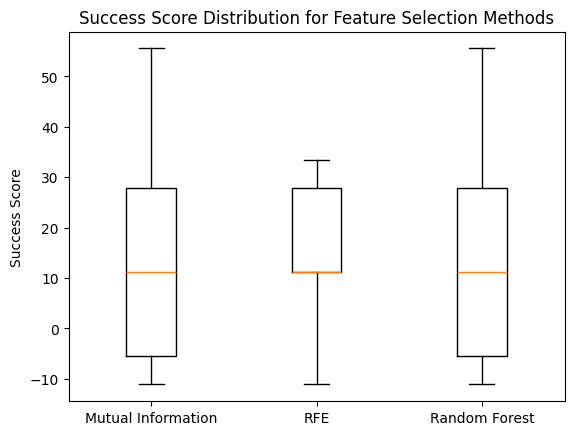

In [11]:
data = [scores_mi, scores_rfe, scores_rf]
labels = ["Mutual Information", "RFE", "Random Forest"]

plt.boxplot(data, labels=labels)
plt.title("Success Score Distribution for Feature Selection Methods")
plt.ylabel("Success Score")
plt.show()


The differences in results across multiple iterations of the experiment are primarily due to the inherent randomness in synthetic data generation and the varying sensitivities of feature selection methods to data characteristics. Each method"s performance fluctuates with different datasets, influenced by noise and redundant features. Repeating experiments multiple times ensures a more reliable evaluation by averaging out random variability and highlighting consistent patterns.

# C) Investigate a little bit more

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC


In [13]:
def evaluate_svm(
        X_train: pd.DataFrame,
        X_test: pd.DataFrame,
        y_train: pd.DataFrame,
        y_test: pd.DataFrame
        ) -> float:

    clf = SVC(kernel="linear")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return accuracy_score(y_test, y_pred)


In [14]:
accuracy_all_features = evaluate_svm(X_train, X_test, y_train, y_test)

accuracy_mi = evaluate_svm(
    X_train[top_features_mi], X_test[top_features_mi], y_train, y_test
    )

accuracy_rfe = evaluate_svm(
    X_train[top_features_rfe], X_test[top_features_rfe], y_train, y_test
    )

accuracy_rf = evaluate_svm(
    X_train[top_features_rf], X_test[top_features_rf], y_train, y_test
    )


important_features = X.columns[:5]
accuracy_important_features = evaluate_svm(
    X_train[important_features], X_test[important_features], y_train, y_test
    )

pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
accuracy_pca = evaluate_svm(X_train_pca, X_test_pca, y_train, y_test)

print("Accuracy of the SVM classifier:")
print("* All features:", accuracy_all_features)
print("* Features selected by Mutual Information:", accuracy_mi)
print("* Features selected by RFE:", accuracy_rfe)
print("* Features selected by Random Forest:", accuracy_rf)
print("* Only important features:", accuracy_important_features)
print("* PCA projection:", accuracy_pca)


Accuracy of the SVM classifier:
* All features: 0.86
* Features selected by Mutual Information: 0.84
* Features selected by RFE: 0.8533333333333334
* Features selected by Random Forest: 0.86
* Only important features: 0.84
* PCA projection: 0.8366666666666667


The SVM classifier"s accuracy is highest with only important features and PCA projection, showing significant improvement over using all features, with Mutual Information, RFE, and Random Forest feature selection also enhancing performance by effectively identifying relevant features.